## Imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

save_dir = 'plots/plot_gen/Roofline/'

# kill old plots
# for f in os.listdir(save_dir):
#     os.remove(os.path.join(save_dir, f))

## Choosing which plot to generate

In [10]:
filenames = [
    "coo_vectorized",
    "sml2_paper",
    "dynamic_warp_csr"
]

save_format = 'eps'

## Reading the profiling and helper functions

In [11]:
metrics = [
    "inst_integer", "inst_compute_ld_st", "ldst_executed", "inst_fp_64", "inst_fp_32",
    "inst_fp_16", "flop_count_dp", "flop_count_sp", "flop_count_hp", "flop_count_dp_fma",
    "local_load_transactions", "local_store_transactions", "local_load_transactions_per_request",
    "local_store_transactions_per_request", "inst_executed_local_loads", "inst_executed_local_stores",
    "shared_load_transactions", "shared_store_transactions", "shared_load_transactions_per_request",
    "shared_store_transactions_per_request", "inst_executed_shared_loads", "inst_executed_shared_stores",
    "gst_transactions", "gld_transactions", "gld_transactions_per_request", "gst_transactions_per_request",
    "inst_executed_global_reductions", "inst_executed_global_loads", "inst_executed_global_stores",
    "l2_read_transactions", "l2_write_transactions", "dram_read_transactions", "dram_write_transactions",
    "sysmem_read_transactions", "sysmem_write_transactions", "ipc", "inst_executed", "thread_inst_executed"
]
# "Event Name" corresponds to a metric
# measurement can be one of these: "Min","Max","Avg","Total"
measurement = "Total"
run_data = pd.read_csv("roofline_data/run_data.csv")

shape_options = ['s', '^', 'd', 'o', 'X']
shape_ctr = 0
data = []

print(run_data)

# Set the filename and time values as given in the MATLAB code
for f in filenames:
    metrics_insights = pd.read_csv("roofline_data/" + f + "_metric.csv")
    event_insights = pd.read_csv("roofline_data/" + f + "_event.csv")
    time = (run_data[run_data["run_name"] == f]["runtime"].astype(float).unique()[0] *
            run_data[run_data["run_name"] == f]["num_blocks"].astype(int).unique()[0] *
            run_data[run_data["run_name"] == f]["invocations"].astype(int).unique()[0]) / 1e6
    data.append((f, metrics_insights, event_insights, time, shape_options[shape_ctr]))
    shape_ctr += 1

def retrieve_from_all_insights(metrics_insights, event_insights, idx):

    if idx <= 35:
        row = metrics_insights.loc[metrics_insights["Metric Name"] == metrics[idx]]
        invo = row["Invocations"].astype(int).unique()[0]
        avg = row["Avg"].astype(int).unique()[0]
        return invo * avg
    else:
        return event_insights.loc[event_insights["Event Name"] == metrics[idx], measurement].astype(int).unique()[0]



           run_name  runtime  num_blocks  invocations
0              test  705.267          25            1
1     request_31_12   73.627           1            8
2        sml2_paper   37.497           1            4
3    coo_vectorized   48.528          10            1
4  dynamic_warp_csr   13.414         160            1


## irf ceilings

In [12]:
l1 = 14 * 1e3 / 32  # B/s
l2 = 2.9968 * 1e3 / 32  # B/s
memBW = 828 / 32

# SM * warp schedulers * instruction_per_cycle * Ghz
peakiop = 80 * 4 * 1 *  1.53  # ops
int_peakiop = 80 * 4 * 1.38 * 0.5
ldst_peakiop = 80 * 4 * 1.38 * 0.25

# Ceilings L1
x = np.logspace(-4, 6, 600)
ceiling2 = np.zeros(len(x))
ceiling21 = np.zeros(len(x))
newx2 = np.zeros(len(x))
cc = 0
for i in range(len(x)):
    if l1 * x[i] < peakiop:
        ceiling2[i] = l1 * x[i]
        ceiling21[cc] = l1 * x[i]
        newx2[cc] = x[i]
        cc += 1
    else:
        ceiling2[i] = peakiop

# Ceilings HBM
ceiling1 = np.zeros(len(x))
ceiling12 = np.zeros(len(x))
newx1 = np.zeros(len(x))
cc = 0
for i in range(len(x)):
    if memBW * x[i] < peakiop:
        ceiling1[i] = memBW * x[i]
        ceiling12[cc] = memBW * x[i]
        newx1[cc] = x[i]
        cc += 1
    else:
        ceiling1[i] = peakiop

# Ceilings L2
memBW = l2
ceiling4 = np.zeros(len(x))
ceiling42 = np.zeros(len(x))
newx4 = np.zeros(len(x))
cc = 0
for i in range(len(x)):
    if memBW * x[i] < peakiop:
        ceiling4[i] = memBW * x[i]
        ceiling42[cc] = memBW * x[i]
        newx4[cc] = x[i]
        cc += 1
    else:
        ceiling4[i] = peakiop

# # Printing the computed values for verification
# print("Ceiling2:", ceiling2)
# print("Ceiling21:", ceiling21)
# print("Newx2:", newx2)
# print("Ceiling1:", ceiling1)
# print("Ceiling12:", ceiling12)
# print("Newx1:", newx1)
# print("Ceiling4:", ceiling4)
# print("Ceiling42:", ceiling42)
# print("Newx4:", newx4)

# # Create the plots
# plt.figure(figsize=(8, 6))

# plt.loglog(x, ceiling2, 'k-', label='Ceiling L1', linewidth=2)
# plt.loglog(newx2, ceiling21, 'r-', label='Ceiling L1 (Zoomed)', linewidth=2)

# plt.loglog(x, ceiling1, 'k-', label='Ceiling HBM', linewidth=2)
# plt.loglog(newx1, ceiling12, 'b-', label='Ceiling HBM (Zoomed)', linewidth=2)

# plt.loglog(x, ceiling4, 'k-', label='Ceiling L2', linewidth=2)
# plt.loglog(newx4, ceiling42, 'g-', label='Ceiling L2 (Zoomed)', linewidth=2)

# plt.grid(True)
# plt.legend()
# plt.show()


## Global Walls

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


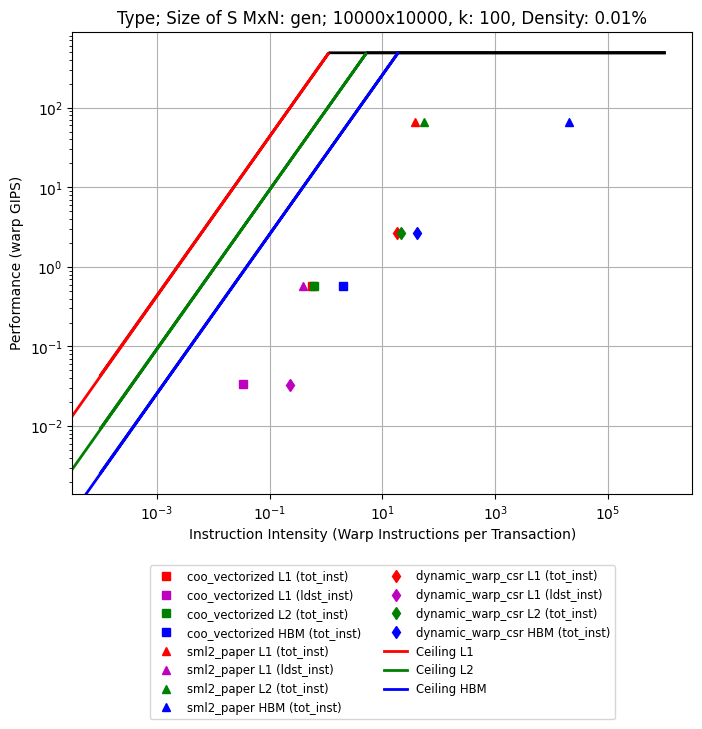

In [13]:

# # Read the CSV file using Pandas
# data = pd.read_csv(filename, header=None)

Tsize = 32
plt.figure(figsize=(8, 6))

implementation_names = []

for (name, mi, ei, rt, shape) in data:

    inst_executed = retrieve_from_all_insights(mi, ei, 36)
    inst_executed_thread = retrieve_from_all_insights(mi, ei, 37)
    inst_integer = retrieve_from_all_insights(mi, ei, 0)
    inst_ldst = (retrieve_from_all_insights(mi, ei, 27) +
                retrieve_from_all_insights(mi, ei, 28))

    # Calculate various transactions and bytes
    # I assumed that global, local and shared transactions are first level

    fstlevelTranscations = (retrieve_from_all_insights(mi, ei, 10) +
                            retrieve_from_all_insights(mi, ei, 11) +
                            retrieve_from_all_insights(mi, ei, 16) +
                            retrieve_from_all_insights(mi, ei, 17) +
                            retrieve_from_all_insights(mi, ei, 22) +
                            retrieve_from_all_insights(mi, ei, 23))
    scndlevelTranscations = (retrieve_from_all_insights(mi, ei, 29) +
                            retrieve_from_all_insights(mi, ei, 30))
    dramlevelTranscations = (retrieve_from_all_insights(mi, ei, 31) +
                            retrieve_from_all_insights(mi, ei, 32))

    # print("FST LVL TRANS")
    # print(fstlevelTranscations)
    # print(type(fstlevelTranscations))
    # print("END")

    fstlevelByte = fstlevelTranscations * Tsize
    scndlevelByte = scndlevelTranscations * Tsize
    dramlevelByte = dramlevelTranscations * Tsize
    globalTranscations = (retrieve_from_all_insights(mi, ei, 22) +
                        retrieve_from_all_insights(mi, ei, 23))

    # Calculate different metrics
    inst_tot = inst_executed_thread / 32
    inst_tot_1 = inst_ldst
    fstAI = inst_tot / fstlevelTranscations
    scndAI = inst_tot / scndlevelTranscations
    dramAI = inst_tot / dramlevelTranscations
    fstAI_1 = inst_tot_1 / globalTranscations

    # Plotting using Matplotlib


    # Plot the log-log plot

    # print(fstAI_1)
    # print(inst_tot_1)

    # plt.loglog(fstAI_1, (inst_tot_1 / 1e9 / rt), 'yo', markersize=8)
    plt.loglog(fstAI, (inst_tot / 1e9 / rt), 'r' + shape, markersize=6, label=name +' L1 (tot_inst)')
    plt.loglog(fstAI_1, (inst_tot_1 / 1e9 / rt), 'm' + shape, markersize=6, label=name +' L1 (ldst_inst)')
    plt.loglog(scndAI, (inst_tot / 1e9 / rt), 'g' + shape, markersize=6, label=name +' L2 (tot_inst)')
    plt.loglog(dramAI, (inst_tot / 1e9 / rt), 'b' + shape, markersize=6, label=name +' HBM (tot_inst)')


    implementation_names.append(name)
# plt.figure(figsize=(8, 6))

plt.loglog(x, ceiling2, 'k-', linewidth=2)
plt.loglog(newx2, ceiling21, 'r-', label='Ceiling L1', linewidth=2)

plt.loglog(x, ceiling4, 'k-', linewidth=2)
plt.loglog(newx4, ceiling42, 'g-', label='Ceiling L2', linewidth=2)

plt.loglog(x, ceiling1, 'k-', linewidth=2)
plt.loglog(newx1, ceiling12, 'b-', label='Ceiling HBM', linewidth=2)




# Additional plot settings
plt.xlabel('Instruction Intensity (Warp Instructions per Transaction)')
plt.ylabel('Performance (warp GIPS)')
if len(data) > 1:
    plt.legend(loc = "lower center", bbox_to_anchor=(0.5, -0.5), fontsize='small', ncol=2)
else:
    plt.legend()
    
plt.grid(True)

final_names = "__".join(implementation_names)

plt.title("Type; Size of S MxN: gen; 10000x10000, k: 100, Density: 0.01%")
plt.savefig(save_dir + "/" + final_names + "__global_walls.png",  bbox_inches='tight', format = "png")
plt.savefig(save_dir + "/" + final_names + "__global_walls.eps",  bbox_inches='tight', format = "eps")
plt.show()


## irf ceilings shared memory

In [14]:
l1 = 14 * 1e3 / 128  # B/s
l2 = 2.9968 * 1e3 / 32  # B/s
memBW = 828 / 32

peakiop = 80 * 4 * 1 * 1.53  # ops

x = np.logspace(-5, 6, 600)
ceiling2 = np.zeros(len(x))
ceiling21 = np.zeros(len(x))
newx2 = []
ceiling1 = np.zeros(len(x))
ceiling12 = np.zeros(len(x))
newx1 = []
ceiling4 = np.zeros(len(x))
ceiling42 = np.zeros(len(x))
newx4 = []

for i in range(len(x)):
    if l1 * x[i] < peakiop:
        ceiling2[i] = l1 * x[i]
        ceiling21[i] = l1 * x[i]
        newx2.append(x[i])
    else:
        ceiling2[i] = peakiop

ceiling21 = ceiling21[:len(newx2)]

for i in range(len(x)):
    if memBW * x[i] < peakiop:
        ceiling1[i] = memBW * x[i]
        ceiling12[i] = memBW * x[i]
        newx1.append(x[i])
    else:
        ceiling1[i] = peakiop

ceiling12 = ceiling12[:len(newx1)]

memBW = l2
for i in range(len(x)):
    if memBW * x[i] < peakiop:
        ceiling4[i] = memBW * x[i]
        ceiling42[i] = memBW * x[i]
        newx4.append(x[i])
    else:
        ceiling4[i] = peakiop

ceiling42 = ceiling42[:len(newx4)]

# plt.figure(figsize=(8, 6))

# plt.loglog(x, ceiling2, 'k-', linewidth=2)
# plt.loglog(newx2, ceiling21, 'r-', linewidth=2)

# plt.loglog(x, ceiling1, 'k-', linewidth=2)
# plt.loglog(newx1, ceiling12, 'b-', linewidth=2)

# plt.loglog(x, ceiling4, 'k-', linewidth=2)
# plt.loglog(newx4, ceiling42, 'g-', linewidth=2)

# plt.grid(True)

# lower_limit = 10 / 1e3

# val1 = 1 / 32
# new_ylim = [lower_limit, l1 * val1]
# plt.plot([val1, val1], new_ylim, 'r-', linewidth=2)
# val2 = 32/32
# new_ylim = [lower_limit, l1 * val2]
# plt.plot([val2, val2], new_ylim, 'r-', linewidth=2)

# plt.xlabel('Instruction Intensity (Warp Instructions per Transaction)')
# plt.ylabel('Performance (warp GIPS)')

# plt.show()


## shared Walls

/tmp/ipykernel_4134376/3137544810.py:64: RuntimeWarning: invalid value encountered in scalar divide
  fstAI_1 = inst_tot_1 / shareTranscations
/tmp/ipykernel_4134376/3137544810.py:64: RuntimeWarning: invalid value encountered in scalar divide
  fstAI_1 = inst_tot_1 / shareTranscations


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


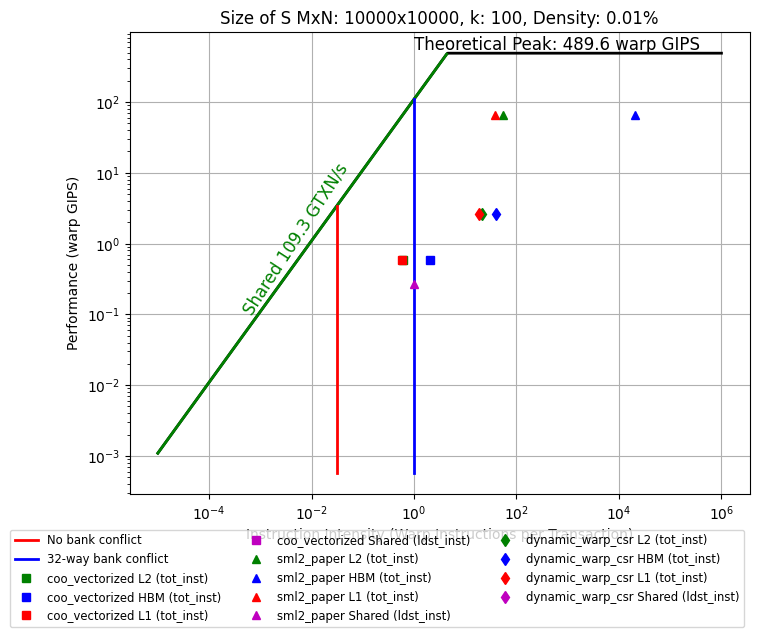

In [15]:
plt.figure(figsize=(8, 6))


plt.loglog(x, ceiling2, 'k-', linewidth=2)
plt.loglog(newx2, ceiling21, 'g-', linewidth=2)
# plt.loglog(x, ceiling1, 'k-', linewidth=2)
# plt.loglog(newx1, ceiling12, 'b-', linewidth=2)

# plt.loglog(x, ceiling4, 'k-', linewidth=2)
# plt.loglog(newx4, ceiling42, 'g-', linewidth=2)

plt.grid(True)

lower_limit = plt.ylim()[0]

val1 = 1 / 32
new_ylim = [lower_limit, l1 * val1]
plt.plot([val1, val1], new_ylim, 'r-', linewidth=2, label='No bank conflict')
val2 = 32/32
new_ylim = [lower_limit, l1 * val2]
plt.plot([val2, val2], new_ylim, 'b-', linewidth=2, label='32-way bank conflict')

plt.text(1, peakiop + 50, 'Theoretical Peak: 489.6 warp GIPS', fontsize=12)
plt.text(0.0004, 0.1, 'Shared 109.3 GTXN/s', fontsize=12, color='g', rotation=57)

implementation_names = []

for (name, mi, ei, rt, shape) in data:
    inst_executed = retrieve_from_all_insights(mi, ei, 36)
    inst_executed_thread = retrieve_from_all_insights(mi, ei, 37)
    inst_integer = retrieve_from_all_insights(mi, ei, 0)
    fstlevelTranscations = (
        retrieve_from_all_insights(mi, ei, 10) +
        retrieve_from_all_insights(mi, ei, 11) +
        retrieve_from_all_insights(mi, ei, 16) +
        retrieve_from_all_insights(mi, ei, 17) +
        retrieve_from_all_insights(mi, ei, 22) +
        retrieve_from_all_insights(mi, ei, 23)
    )
    scndlevelTranscations = (
        retrieve_from_all_insights(mi, ei, 29) +
        retrieve_from_all_insights(mi, ei, 30)
    )
    dramlevelTranscations = (
        retrieve_from_all_insights(mi, ei, 31) +
        retrieve_from_all_insights(mi, ei, 32)
    )

    inst_ldst = (
    retrieve_from_all_insights(mi, ei, 20) +
    retrieve_from_all_insights(mi, ei, 21)
    )
    shareTranscations = (
        retrieve_from_all_insights(mi, ei, 16) +
        retrieve_from_all_insights(mi, ei, 17)
    )

    inst_tot = inst_executed_thread / 32
    inst_tot_1 = inst_ldst

    fstAI = inst_tot / fstlevelTranscations
    scndAI = inst_tot / scndlevelTranscations
    dramAI = inst_tot / dramlevelTranscations
    fstAI_1 = inst_tot_1 / shareTranscations

    # plt.loglog(fstAI_1, (inst_tot_1 / 1e9 / rt), 'yo', markersize=8, markerfacecolor='y', linewidth=2)
    plt.loglog(scndAI, (inst_tot / 1e9 / rt), 'g' + shape, markersize=6, label=name +' L2 (tot_inst)')
    plt.loglog(dramAI, (inst_tot / 1e9 / rt), 'b'+ shape, markersize=6, label=name +' HBM (tot_inst)')
    plt.loglog(fstAI, (inst_tot / 1e9 / rt), 'r'+ shape, markersize=6, label=name +' L1 (tot_inst)')
    plt.loglog(fstAI_1, (inst_tot_1 / 1e9 / rt), 'm'+ shape, markersize=6, linewidth=2, label=name +' Shared (ldst_inst)')

    implementation_names.append(name)


# Additional plot settings
plt.xlabel('Instruction Intensity (Warp Instructions per Transaction)')
plt.ylabel('Performance (warp GIPS)')
if len(data) > 1:
    plt.legend(loc = "lower right", bbox_to_anchor=(1, -0.3), fontsize='small', ncol=3)
else:
    plt.legend()
plt.grid(True)

final_names = "__".join(implementation_names)

plt.title("Size of S MxN: 10000x10000, k: 100, Density: 0.01%")
plt.savefig(save_dir + "/" + final_names + "__shared_walls.png",  bbox_inches='tight', format = "png")
plt.savefig(save_dir + "/" + final_names + "__shared_walls.eps",  bbox_inches='tight', format = "eps")

plt.show()
